In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
# read data
data_path = '../Data/lineage_result_lasI_without_forML.csv'
# data_path_1 = './lineage_result_lasI_with.csv'

df_without = pd.read_csv(data_path)
# df_with = pd.read_csv(data_path_1)

# df = pd.concat([df_without, df_with], axis=0)

In [3]:
# set plot sytle
sns.set(
    style='ticks', 
    context='talk', 
    palette='colorblind',
    rc={
        "axes.spines.top": False, 
        "axes.spines.right": False,
        "figure.figsize": (10, 6)
    }
)

In [5]:
# import re

# df['generation'] = df['cid'].apply(lambda x: int(re.search(r'_(\d+)', x).group(1)))

In [4]:
df = df_without.copy()

In [5]:
def calculate_gfp_peak(group):
    group['sister_gfp'] = group.apply(lambda row: group.loc[group['cid'] == row['sid'], 'gfp.peak'].values[0] if row['sid'] in group['cid'].values else None, axis=1)
    group['neighbour_gfp'] = group.apply(lambda row: group.loc[group['cid'] == row['ncid'], 'gfp.peak'].values[0] if row['ncid'] in group['cid'].values else None, axis=1)
    return group

# calculate GFP peak for sister and neighbour cells
df = df.groupby('cluster', group_keys=False).apply(calculate_gfp_peak)

# pick the features
df_ml = df.drop(columns=['Unnamed: 0', 'lineage', 'ngfp.mean', 'gene', 'sid', 'ncid', 'rcid', 'Autoinducer'])
df_ml.set_index('cid', inplace=True)

# encoder = LabelEncoder()
# df_ml['Autoinducer'] = encoder.fit_transform(df_ml['Autoinducer'])
# df_ml = df_ml.dropna()

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_76607/828299268.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cluster', group_keys=False).apply(calculate_gfp_peak)


## 15 features

In [8]:
# fit a random forest model
# 1. Load the dataset
X = df_ml.drop(columns='gfp.peak')  # Features
y = df_ml['gfp.peak']  # Labels

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Create a Random Forest classifier
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees in the forest
    max_depth=5,           # Maximum depth of each tree
    random_state=42,       # Ensure reproducibility
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1     # Minimum number of samples required at a leaf node
)

# 4. Train the Random Forest model
rf_model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = rf_model.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# # 7. Feature importance
# print("\nFeature Importances:")
# for feature, importance in zip(X.columns, rf_model.feature_importances_):
#     print(f"{feature}: {importance:.4f}")
    
# # 7. Feature importance
# importances = sorted(zip(X.columns, rf_model.feature_importances_), key=lambda x: x[1], reverse=True)
# print("\nFeature Importances (ordered from higher to lower):")
# for feature, importance in importances:
#     print(f"{feature}: {importance:.4f}")
    
# 7. Feature importance
importances = sorted(zip(X.columns, rf_model.feature_importances_), key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in importances:
    print(f"{feature:20} {importance:.4f}")

Mean Squared Error (MSE): 3155.11
Mean Absolute Error (MAE): 35.19
R^2 Score: 0.96

Feature Importances:
gfp.mean             0.9826
cell.lifespan        0.0054
first.frame          0.0037
y.mean               0.0021
sister_gfp           0.0017
neighbour_gfp        0.0013
cell.length          0.0007
x.mean               0.0006
cell.aspect_ratio    0.0005
mcherry.mean         0.0005
dist                 0.0003
mcherry.peak         0.0003
cluster              0.0002
series               0.0000


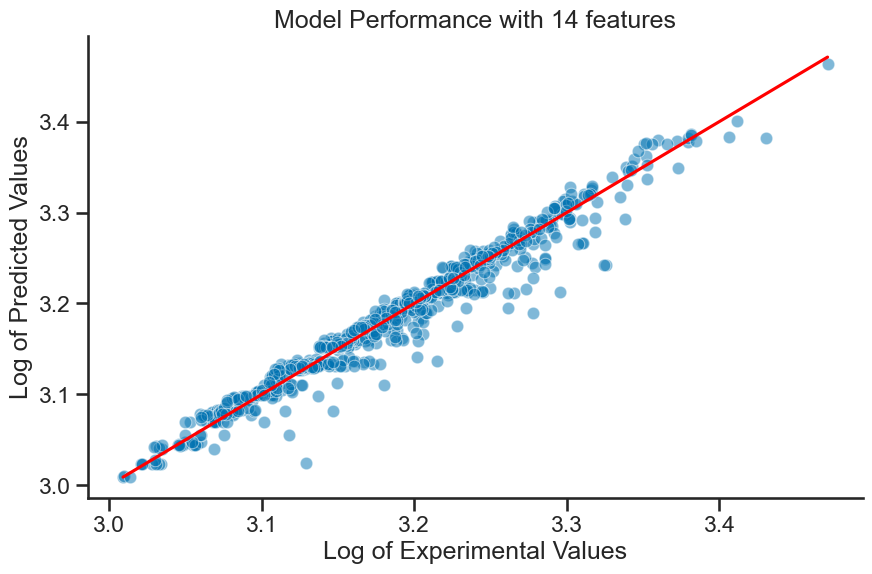

In [9]:
# Take the log10 value of y_test and y_pred
y_test_log = np.log10(y_test)
y_pred_log = np.log10(y_pred)

sns.scatterplot(x=y_test_log, y=y_pred_log, alpha=0.5)
plt.xlabel('Log of Experimental Values')
plt.ylabel('Log of Predicted Values')
plt.title('Model Performance with 14 features')
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red')  # Line of perfect prediction
plt.show()

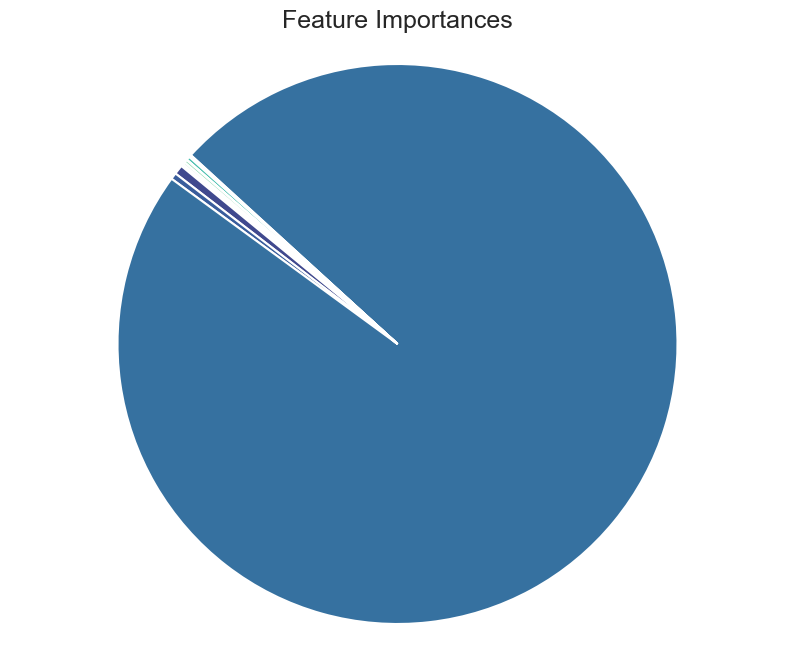

In [10]:
features = X.columns
importances = rf_model.feature_importances_

# 绘制饼图
# Define a color palette
colors = sns.color_palette('mako', len(importances))

plt.figure(figsize=(10, 8))
plt.pie(importances, colors=colors, startangle=140)
plt.title('Feature Importances')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 14 features

In [11]:
df_ml2 = df_ml.drop(columns='gfp.mean')

# 1. Load the dataset
X = df_ml2.drop(columns='gfp.peak')  # Features
y = df_ml2['gfp.peak']  # Labels

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Create a Random Forest classifier
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees in the forest
    max_depth=5,           # Maximum depth of each tree
    random_state=42,       # Ensure reproducibility
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1     # Minimum number of samples required at a leaf node
)

# 4. Train the Random Forest model
rf_model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = rf_model.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# # 7. Feature importance
# print("\nFeature Importances:")
# for feature, importance in zip(X.columns, rf_model.feature_importances_):
#     print(f"{feature}: {importance:.4f}")

# 7. Feature importance
importances = sorted(zip(X.columns, rf_model.feature_importances_), key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in importances:
    print(f"{feature:20} {importance:.4f}")

Mean Squared Error (MSE): 20910.27
Mean Absolute Error (MAE): 99.48
R^2 Score: 0.71

Feature Importances:
sister_gfp           0.8910
neighbour_gfp        0.0317
dist                 0.0163
cluster              0.0113
x.mean               0.0093
first.frame          0.0074
cell.aspect_ratio    0.0061
cell.length          0.0056
cell.lifespan        0.0053
mcherry.peak         0.0050
mcherry.mean         0.0043
y.mean               0.0043
series               0.0024


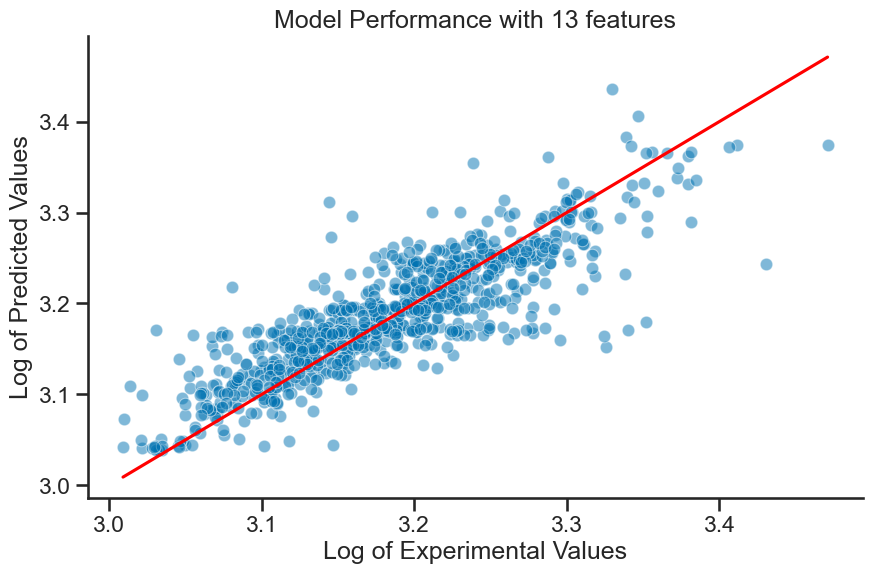

In [12]:
# Take the log10 value of y_test and y_pred
y_test_log = np.log10(y_test)
y_pred_log = np.log10(y_pred)

sns.scatterplot(x=y_test_log, y=y_pred_log, alpha=0.5)
plt.xlabel('Log of Experimental Values')
plt.ylabel('Log of Predicted Values')
plt.title('Model Performance with 13 features')
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red')  # Line of perfect prediction
plt.show()

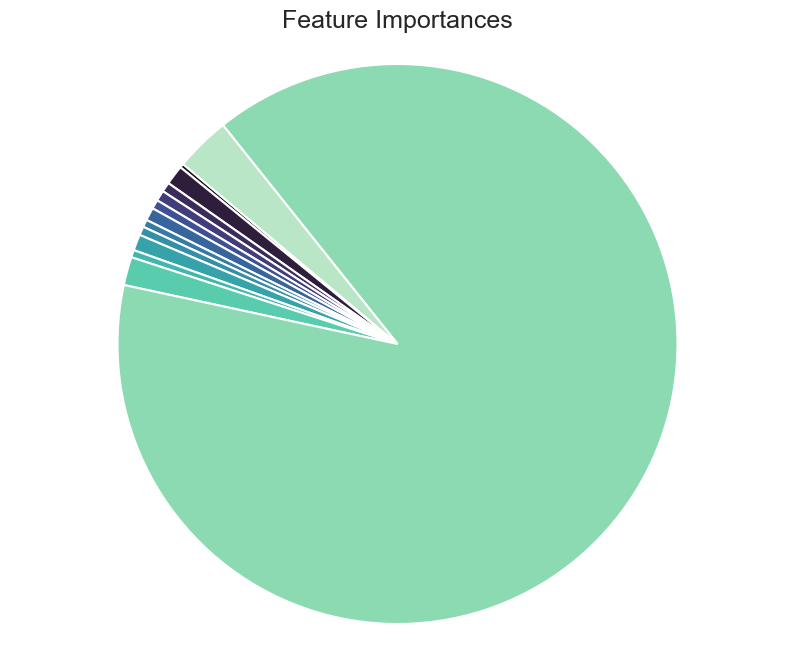

In [13]:
features = X.columns
importances = rf_model.feature_importances_

# 绘制饼图
# Define a color palette
colors = sns.color_palette('mako', len(importances))

plt.figure(figsize=(10, 8))
plt.pie(importances, colors=colors, startangle=140)
plt.title('Feature Importances')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## 13 features

In [6]:
df_ml3 = df_ml.drop(columns=['gfp.mean','sister_gfp'])

# 1. Load the dataset
X = df_ml3.drop(columns='gfp.peak')  # Features
y = df_ml3['gfp.peak']  # Labels

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Create a Random Forest classifier
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees in the forest
    max_depth=5,           # Maximum depth of each tree
    random_state=42,       # Ensure reproducibility
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1     # Minimum number of samples required at a leaf node
)

# 4. Train the Random Forest model
rf_model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = rf_model.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# # 7. Feature importance
# print("\nFeature Importances:")
# for feature, importance in zip(X.columns, rf_model.feature_importances_):
#     print(f"{feature}: {importance:.4f}")

# 7. Feature importance
importances = sorted(zip(X.columns, rf_model.feature_importances_), key=lambda x: x[1], reverse=True)
print("\nFeature Importances:")
for feature, importance in importances:
    print(f"{feature:20} {importance:.4f}")

Mean Squared Error (MSE): 42218.31
Mean Absolute Error (MAE): 152.83
R^2 Score: 0.42

Feature Importances:
neighbour_gfp        0.6027
dist                 0.1262
first.frame          0.0671
x.mean               0.0644
y.mean               0.0515
mcherry.mean         0.0204
mcherry.peak         0.0192
cell.length          0.0142
cell.lifespan        0.0125
cell.aspect_ratio    0.0121
cluster              0.0067
series               0.0030


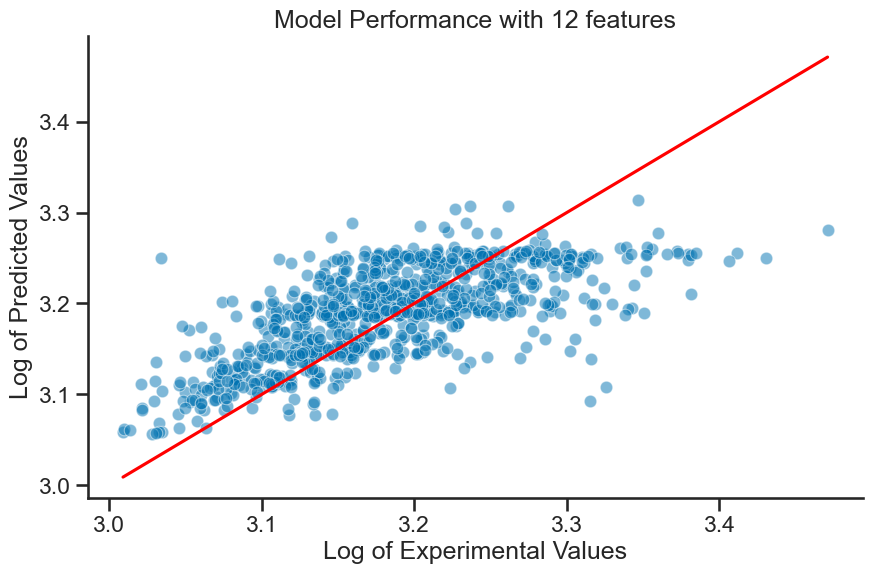

In [7]:
# Take the log10 value of y_test and y_pred
y_test_log = np.log10(y_test)
y_pred_log = np.log10(y_pred)

sns.scatterplot(x=y_test_log, y=y_pred_log, alpha=0.5)
plt.xlabel('Log of Experimental Values')
plt.ylabel('Log of Predicted Values')
plt.title('Model Performance with 12 features')
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red')  # Line of perfect prediction
plt.show()

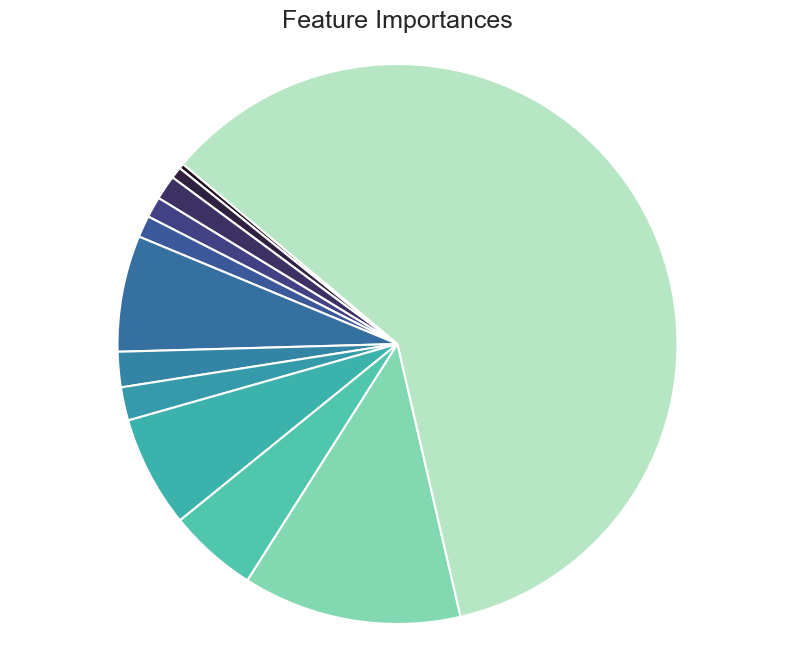

In [16]:
features = X.columns
importances = rf_model.feature_importances_

# 绘制饼图
# Define a color palette
colors = sns.color_palette('mako', len(importances))

plt.figure(figsize=(10, 8))
plt.pie(importances, colors=colors, startangle=140)
plt.title('Feature Importances')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()